# GAUSSIAN PROCESS


To implement a Gaussian Process and determine the threshold, you can follow these general steps:

1. Data Collection: Gather a set of calibration points. These are measurements paired with corresponding thresholds that you want to achieve.

2. Gaussian Process Modeling: Fit a Gaussian Process model to the collected data. This involves defining a mean function and a covariance function (kernel), and estimating the hyperparameters that best describe the data.

3. Predictive Distribution: Use the fitted Gaussian Process model to make predictions for unseen threshold values. This will provide you with a predictive mean and the associated confidence intervals.

4. Threshold Optimization: Determine the minimum number of measurements needed to achieve a desired maximum broadness of the confidence interval (threshold).

    a. Run the code multiple times with different numbers of calibration points.
    
    b. For each run, calculate the broadness of the confidence interval and compare it with the desired threshold.
    
    c. If the broadness is smaller than the threshold, you have achieved the desired result. If not, adjust the number of calibration points and retry.

5. Repeat Steps 3 and 4: Iterate through Steps 3 and 4 until the desired threshold is reached. This may involve refining the Gaussian Process model and fine-tuning the number of calibration points.

By iteratively adjusting the number of calibration points and using the Gaussian Process model, you can search for the minimum number of points required to achieve your desired threshold.


Here's a more detailed explanation of Step 4b, considering the use of a separate test set:

1. Split the data: Divide your dataset into a training set and a test set. The training set is used to fit the Gaussian Process model, while the test set is used to evaluate the performance of the model.

2. Fit the Gaussian Process model: Use the training set to fit the Gaussian Process model by estimating the hyperparameters and training the model.

3. Predict confidence intervals: Apply the trained model to the test set to predict the mean and variance for each threshold value.

4. Calculate upper and lower confidence bounds: Calculate the upper and lower bounds of the confidence interval based on the predicted mean and variance. This can be done by multiplying the standard deviation by a multiple corresponding to the desired level of confidence (e.g., 1.96 for 95% confidence interval).

5. Determine the broadness: Compute the broadness of the confidence interval by subtracting the lower bound from the upper bound for each threshold value in the test set. This yields an array or list of broadness values.

6. Compare with the desired threshold: Compare the calculated broadness values with the desired threshold value. If the broadness is smaller than the threshold, it indicates that the confidence intervals obtained from the model are sufficiently narrow for that number of calibration points. If not, adjustments to the number of calibration points may be necessary.

By calculating the broadness of the confidence intervals based on a separate test set, you can appropriately assess the performance and accuracy of the Gaussian Process model and make informed decisions regarding the number of calibration points needed to meet your desired threshold.


In [2]:
#load the required packages

%matplotlib inline  

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Generate the Data

Let's suppose that we can measure a temperature in the range 288.15K-298.15K (15-25 °C). 
Let's suppose we have 10 measurements for each increasing in 1K. And suppose that we have a threshold of 3$\sigma$

In [3]:
# Define temperature range in Kelvin
min_temperature = 288.15  # 15°C in Kelvin
max_temperature = 338.15  # 25°C in Kelvin

# Number of measurements for each 1K increase
num_measurements_per_1K = 100

# Generate temperature data
temperatures = np.arange(min_temperature, max_temperature + 1, 1)  # Temperatures from 288.15K to 298.15K

# Generate random measurements for each temperature point
np.random.seed(10)  # For reproducibility
measurements = np.random.normal(loc=temperatures.reshape(-1, 1), scale=0.5, size=(len(temperatures), num_measurements_per_1K))

# Calculate mean and standard deviation for each temperature point
means = np.mean(measurements, axis=1)
std_devs = np.std(measurements, axis=1)

# Calculate threshold (3σ)
threshold = 3 * std_devs

# Print the generated data for one temperature point (e.g., 290.15K)
print("Temperature (K):", temperatures[2])  # Considering 290.15K as an example
print("Measurements:", measurements[2])
print("Mean:", means[2])
print("Standard Deviation:", std_devs[2])
print("Threshold (3σ):", threshold[2])


Temperature (K): 290.15
Measurements: [290.21656875 290.75137194 289.63762352 290.23019958 289.58476236
 289.17935016 290.64329891 290.16411368 289.7388162  289.35672412
 289.94926359 290.82108964 290.35123455 289.96361929 289.81398828
 290.20290604 289.3763473  290.82240326 290.40159459 290.7471753
 289.86824716 290.57741438 290.49395236 289.38346564 290.22448035
 290.30755558 289.86254117 289.96991443 290.36809265 290.13104106
 289.64764182 290.44572654 290.26390868 290.27458933 290.19788162
 290.37451087 290.006999   289.71862085 289.77908758 290.70278757
 289.14114067 290.42027036 289.42885056 289.34557482 289.64671572
 290.02123319 290.51525372 289.30079925 290.98703777 290.73186185
 290.0837132  290.0048771  289.67323379 290.4440203  290.18440074
 290.85603215 289.80689219 290.42397196 290.13180873 289.72649187
 291.10115202 290.2898027  290.46012725 289.61571615 289.78868963
 290.19206978 289.85777242 290.45101114 290.36918262 289.7588284
 290.24646799 290.15201246 290.06796235 

## Generate training set and test set

In [4]:
# Concatenate temperatures with errors and label them

ID =2063594# place a random seed
np.random.seed(ID)
data_with_labels = np.column_stack((means, threshold))

# Random permute the data and split into training and test taking the first 7
# data samples as training and 3 samples as test
X=means
y=std_devs
rng = np.random.RandomState(1)
training_indices = rng.choice(np.arange(y.size), size=10, replace=False)
X_train, y_train = X[training_indices], y[training_indices]

# Creare un array di indici per il set di test
test_indices = np.setdiff1d(np.arange(y.size), training_indices)

# Creare il set di test utilizzando gli indici
X_test, y_test = X[test_indices], y[test_indices]


permutation = np.random.permutation(X.shape[0])

#X = X[permutation]
#y = y[permutation]

#m_training = 7
#m_test = 3

#X_train, X_test = X[:m_training], X[m_training:m_training+m_test:]
#y_train, y_test = y[:m_training], y[m_training:m_training+m_test:]

labels, freqs = np.unique(y_train, return_counts=True)
print("Labels in training dataset: ", labels)
print("Frequencies in training dataset: ", freqs)

Labels in training dataset:  [0.45667355 0.45878993 0.46661538 0.47464619 0.49353352 0.5121872
 0.52106181 0.52136032 0.53545018 0.56719122]
Frequencies in training dataset:  [1 1 1 1 1 1 1 1 1 1]


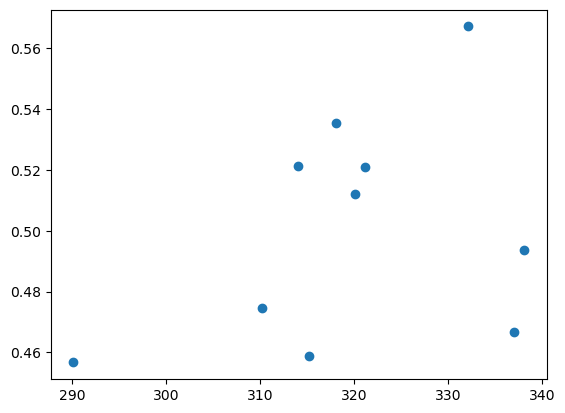

In [5]:
##plot training test
plt.scatter(X_train,y_train)

## FIT GAUSSIAN PROCESS WITH SCIKIT-LEARN

In [6]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

In [7]:
# Reshape the input data to 2D array
X_train = X_train.reshape(-1, 1)


kernel = 1 * RBF(length_scale=1)
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gaussian_process.fit(X_train, y_train)
gaussian_process.kernel_



0.442**2 * RBF(length_scale=3.04)

## MAKE PREDICTION

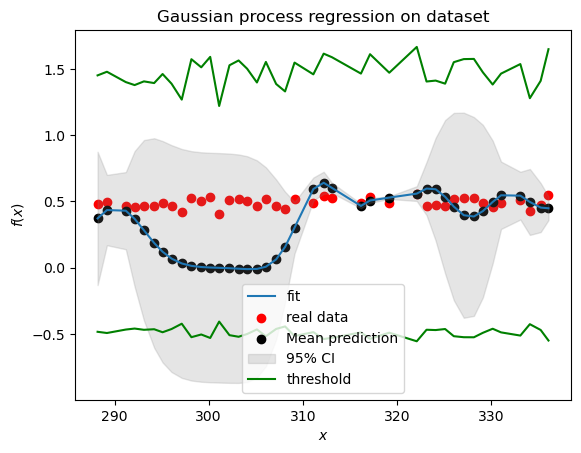

In [8]:
X_test=X_test.reshape(-1,1)

mean_prediction, std_prediction = gaussian_process.predict(X_test, return_std=True)


X_train = X_train.reshape(-1, 1)
X_test=X_test.reshape(-1,1)

#plt.scatter(X_train, y_train, label="Observations")

plt.plot(X_test, mean_prediction, label="fit")

plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression on dataset")


# Assuming X_test, y_test, mean_prediction, and std_prediction are defined

plt.scatter(X_test, y_test,color="red",label="real data")
plt.scatter(X_test, mean_prediction,color="black", label="Mean prediction")
# Flatten the m ltidimensional X_test array
X_test_flat = X_test.flatten()
# Fill the region between the red lines
plt.fill_between(X_test_flat, (mean_prediction - 1.96 * std_prediction).flatten(), (mean_prediction + 1.96 * std_prediction).flatten(), color='grey', alpha=0.2,label="95% CI")
plt.plot(X_test, y_test + 2 * y_test, color="green",label="threshold")
plt.plot(X_test, y_test - 2 * y_test, color="green")
plt.legend()
plt.show()


In [9]:
from sklearn.metrics import mean_absolute_error
# Calculate Mean Absolute Error
mae = mean_absolute_error(y_test, mean_prediction)
print("Mean Absolute Error (MAE):", mae)


Mean Absolute Error (MAE): 0.21204976389142338


## COMPARISON WITH THRESHOLD

In [10]:
count = 0
for index, prediction in enumerate(mean_prediction):
    if (abs(prediction + 1.96 * std_prediction[index]-(prediction - 1.96 * std_prediction[index])) > abs(y_test[index]+2*y_test[index]-(y_test[index]-2*y_test[index]))):
        count=count+1

if count > 0:
    print("Add more measuraments")
else:
    print("good number of measuraments")


Add more measuraments


## 3D GAUSSIAN PROCESS

In [11]:

import numpy as np
import pandas as pd

# Define temperature range in Kelvin
min_temperature = 288.15  # 15°C in Kelvin
max_temperature = 338.15  # 25°C in Kelvin

# Define pressure range in bars
min_pressure = 1  # Minimum pressure in bars
max_pressure = 50  # Maximum pressure in bars

# Number of measurements for each 1K increase
num_measurements_per_1K = 100

# Generate temperature and pressure data
temperatures = np.arange(min_temperature, max_temperature + 1, 1)  # Temperatures from 288.15K to 298.15K
pressures = np.linspace(min_pressure, max_pressure, len(temperatures))  # Linearly spaced pressures from 1 bar to 50 bars

# Generate random measurements for each temperature point
np.random.seed(10)  # For reproducibility
temperature_measurements = np.random.normal(loc=temperatures.reshape(-1, 1), scale=0.5, size=(len(temperatures), num_measurements_per_1K))

# Generate random measurements for each pressure point
pressure_measurements = np.random.normal(loc=pressures.reshape(-1, 1), scale=0.5, size=(len(pressures), num_measurements_per_1K))

# Calculate mean and standard deviation for each temperature point
means_t = np.mean(temperature_measurements, axis=1)
std_devs_t = np.std(temperature_measurements, axis=1)

# Calculate mean and standard deviation for each temperature point
means_p = np.mean(pressure_measurements, axis=1)
std_devs_p = np.std(pressure_measurements, axis=1)


# Create DataFrame
df = pd.DataFrame({
    'means_t': means_t,
    'means_p': means_p,
    'std_devs_t': std_devs_t,
    'std_devs_p': std_devs_p
})

# Print the DataFrame
print(df.head())

      means_t   means_p  std_devs_t  std_devs_p
0  288.189708  1.044610    0.483520    0.450378
1  289.184599  1.989414    0.492667    0.453159
2  290.138047  2.892339    0.456674    0.450213
3  291.189795  3.973498    0.466657    0.524003
4  292.125375  4.851289    0.459155    0.457798


In [12]:
from sklearn.model_selection import train_test_split

# Splitting features (X) and labels (Y)
X = df[['means_t', 'means_p']]
Y = df[['std_devs_t', 'std_devs_p']]

# Splitting the data into train and test sets (80% train, 20% test)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Printing the shapes of the train and test sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", Y_train.shape)
print("Y_test shape:", Y_test.shape)


X_train shape: (40, 2)
X_test shape: (11, 2)
Y_train shape: (40, 2)
Y_test shape: (11, 2)


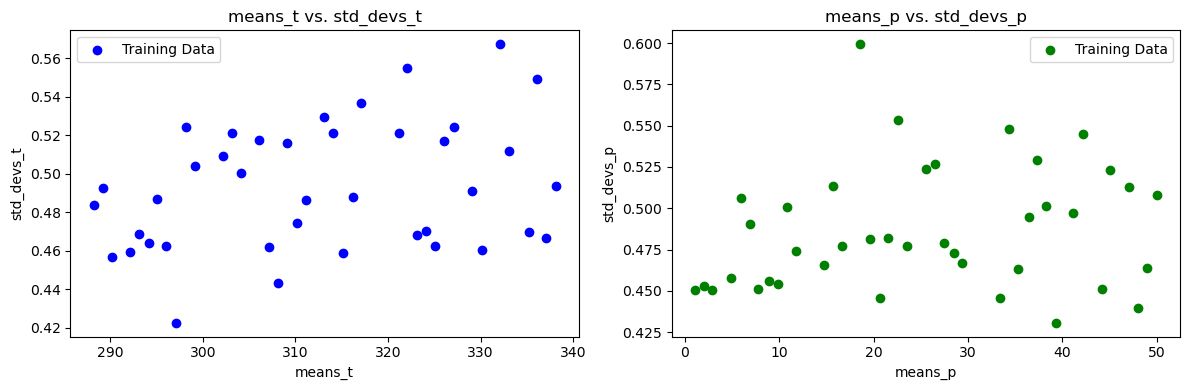

In [13]:
import matplotlib.pyplot as plt

# Scatter plot for means_t vs. std_devs_t
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.scatter(X_train['means_t'], Y_train['std_devs_t'], color='blue', label='Training Data')
plt.xlabel('means_t')
plt.ylabel('std_devs_t')
plt.title('means_t vs. std_devs_t')
plt.legend()

# Scatter plot for means_p vs. std_devs_p
plt.subplot(1, 2, 2)
plt.scatter(X_train['means_p'], Y_train['std_devs_p'], color='green', label='Training Data')
plt.xlabel('means_p')
plt.ylabel('std_devs_p')
plt.title('means_p vs. std_devs_p')
plt.legend()

plt.tight_layout()
plt.show()


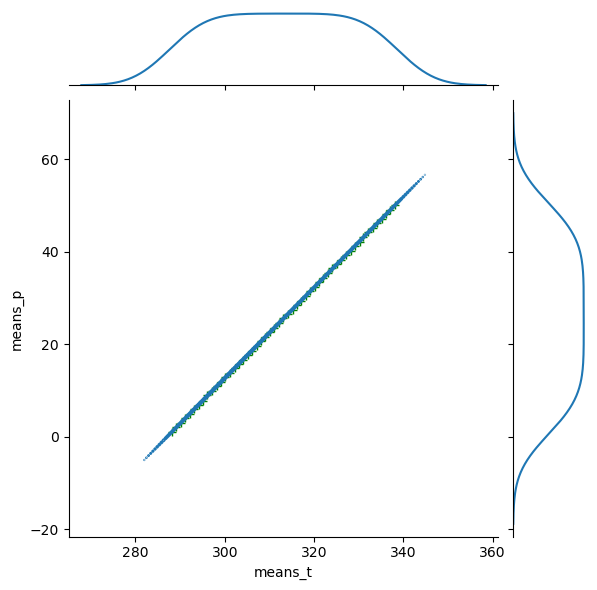

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have already created the 'df' DataFrame

# Create a jointplot with kernel density estimation
g = sns.jointplot(x='means_t', y='means_p', data=df, kind="kde")

# Add scatter plot on top of the jointplot
g.plot_joint(plt.scatter, c="g", s=30, linewidth=1, marker="+")


# Show the plot
plt.show()


## GAUSSIAN FIT AND PREDICTION

In [15]:
kernel = 1 * RBF(length_scale=1)
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gaussian_process.fit(X_train, Y_train)
gaussian_process.kernel_

0.372**2 * RBF(length_scale=2.25)

In [16]:
mean_prediction, std_prediction = gaussian_process.predict(X_test, return_std=True)

## Pressure

In [17]:
X_test_p=np.array(X_test["means_p"])
X_train_p=np.array(X_train["means_p"])
mean_prediction_p=np.array( mean_prediction[:,1])
Y_test_p=np.array(Y_test["std_devs_p"])
Y_train_p=np.array(Y_train["std_devs_p"])
std_prediction_p=np.array( std_prediction[:,1])
X_test_p=X_test_p.reshape(-1,1)

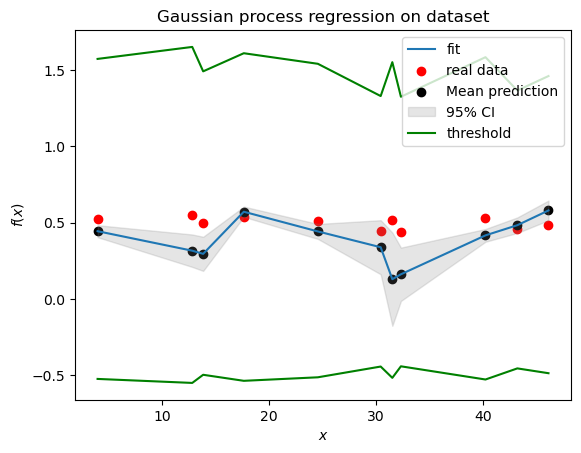

In [18]:
# Supponendo che X_test_p, mean_prediction_p, Y_test_p, e std_prediction_p siano definiti

# Ottieni gli indici che ordinano l'array X_test_p in ordine crescente
sorted_indices = np.argsort(X_test_p.flatten())

# Ordina gli array in base agli indici ottenuti
X_test_sorted = X_test_p[sorted_indices]
mean_prediction_sorted = mean_prediction_p[sorted_indices]
Y_test_sorted = Y_test_p[sorted_indices]
std_prediction_sorted = std_prediction_p[sorted_indices]

# Ora puoi utilizzare X_test_sorted, mean_prediction_sorted, Y_test_sorted, e std_prediction_sorted
# per il plotting ordinato.
plt.plot(X_test_sorted, mean_prediction_sorted, label="fit")
plt.scatter(X_test_sorted, Y_test_sorted, color="red", label="real data")
plt.scatter(X_test_sorted, mean_prediction_sorted, color="black", label="Mean prediction")

# Calcola la regione di confidenza ordinata
lower_bound = mean_prediction_sorted - 1.96 * std_prediction_sorted
upper_bound = mean_prediction_sorted + 1.96 * std_prediction_sorted

# Riempi la regione tra i limiti
plt.fill_between(X_test_sorted.flatten(), lower_bound.flatten(), upper_bound.flatten(), color='grey', alpha=0.2, label="95% CI")

# Traccia la soglia ordinata
plt.plot(X_test_sorted, Y_test_sorted + 2 * Y_test_sorted, color="green", label="threshold")
plt.plot(X_test_sorted, Y_test_sorted - 2 * Y_test_sorted, color="green")

plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.title("Gaussian process regression on dataset")
plt.show()


In [19]:
count = 0
for index, prediction in enumerate(mean_prediction_p):
    if (abs(prediction + 1.96 * std_prediction_p[index]-(prediction - 1.96 * std_prediction_p[index])) > abs(Y_test_p[index]+2*Y_test_p[index]-(Y_test_p[index]-2*Y_test_p[index]))):
        count=count+1

if count > 0:
    print("Add more measuraments")
else:
    print("good number of measuraments")

good number of measuraments


## Temperature

In [20]:
X_test_t=np.array(X_test["means_t"])
X_train_t=np.array(X_train["means_t"])
mean_prediction_t=np.array( mean_prediction[:,0])
Y_test_t=np.array(Y_test["std_devs_t"])
Y_train_t=np.array(Y_train["std_devs_t"])
std_prediction_t=np.array( std_prediction[:,0])
X_test_t=X_test_t.reshape(-1,1)

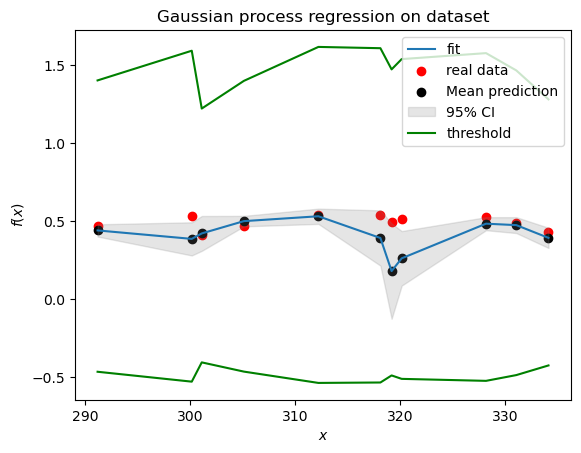

In [21]:
# Supponendo che X_test_p, mean_prediction_p, Y_test_p, e std_prediction_p siano definiti

# Ottieni gli indici che ordinano l'array X_test_p in ordine crescente
sorted_indices = np.argsort(X_test_t.flatten())

# Ordina gli array in base agli indici ottenuti
X_test_sorted = X_test_t[sorted_indices]
mean_prediction_sorted = mean_prediction_t[sorted_indices]
Y_test_sorted = Y_test_t[sorted_indices]
std_prediction_sorted = std_prediction_t[sorted_indices]

# Ora puoi utilizzare X_test_sorted, mean_prediction_sorted, Y_test_sorted, e std_prediction_sorted
# per il plotting ordinato.
plt.plot(X_test_sorted, mean_prediction_sorted, label="fit")
plt.scatter(X_test_sorted, Y_test_sorted, color="red", label="real data")
plt.scatter(X_test_sorted, mean_prediction_sorted, color="black", label="Mean prediction")

# Calcola la regione di confidenza ordinata
lower_bound = mean_prediction_sorted - 1.96 * std_prediction_sorted
upper_bound = mean_prediction_sorted + 1.96 * std_prediction_sorted

# Riempi la regione tra i limiti
plt.fill_between(X_test_sorted.flatten(), lower_bound.flatten(), upper_bound.flatten(), color='grey', alpha=0.2, label="95% CI")

# Traccia la soglia ordinata
plt.plot(X_test_sorted, Y_test_sorted + 2 * Y_test_sorted, color="green", label="threshold")
plt.plot(X_test_sorted, Y_test_sorted - 2 * Y_test_sorted, color="green")

plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.title("Gaussian process regression on dataset")
plt.show()

In [22]:
count = 0
for index, prediction in enumerate(mean_prediction_p):
    if (abs(prediction + 1.96 * std_prediction_p[index]-(prediction - 1.96 * std_prediction_p[index])) > abs(Y_test_p[index]+2*Y_test_p[index]-(Y_test_p[index]-2*Y_test_p[index]))):
        count=count+1

if count > 0:
    print("Add more measuraments")
else:
    print("good number of measuraments")

good number of measuraments
